In [1]:
import torch
from torch.utils.data import Dataset
import rasterio
from rasterio.windows import Window
from rasterio.windows import from_bounds
from typing import Optional, Union, overload
import math
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
class noTBoundingBox():
    def __init__(self, minx, maxx, miny, maxy):
        self.minx = minx
        self.maxx = maxx
        self.miny = miny
        self.maxy = maxy

def single_sample_collate_fn(batch):
    sample = batch[0]
    sample['top_lft_index'] = [sample['top_lft_index']]
    sample['bbox'] = [sample['bbox']]
    return sample


class SingleTileDataset(Dataset):
    """
    To be used with SinglePatchSampler
    """
    def __init__(self, tiff_path, tile_aoi_gdf, aoi_mask):
        self.tiff_path = tiff_path
        self.tile_aoi_gdf = tile_aoi_gdf
        self.aoi_mask = aoi_mask
        with rio.open(tiff_path) as src:
            self.to_index = src.index
            self.to_xy = src.xy
            self.tile_shape = (src.height, src.width)
            self.height, self.width = self.tile_shape
            self.transform = src.transform #pxl to geo
            self.bounds = src.bounds #geo coords
            self.res = src.res

    def __getitem__(self, bbox):
        minx, maxx, miny, maxy = bbox #geo coords
        with rio.open(self.tiff_path) as dataset:
            window = from_bounds(minx, miny, maxx, maxy, dataset.transform)
            patch_data = dataset.read(window=window, boundless=True)
        patch_tensor = torch.from_numpy(patch_data).float()
        sample = {'image': patch_tensor, #(1,3,h,w)
                  'bbox': noTBoundingBox(minx, maxx, miny, maxy),
                  'top_lft_index': self.to_index(minx, maxy)}
        return sample

In [5]:
class TiffPatchDataset(Dataset):
    def __init__(self, tiff_path):
        self.tiff_path = tiff_path
        with rasterio.open(tiff_path) as src:
            self.width, self.height = src.width, src.height #pxls
            self.transform = src.transform #pxl to geo
            self.bounds = src.bounds #geo coords

    def __getitem__(self, bbox):
        minx, maxx, miny, maxy = bbox #geo coords
        with rasterio.open(self.tiff_path) as dataset:
            window = from_bounds(minx, miny, maxx, maxy, dataset.transform)
            patch_data = dataset.read(window=window, boundless=True)
        patch_tensor = torch.from_numpy(patch_data).float()
        return patch_tensor

In [6]:
class BoundingBoxSampler:
    def __init__(self, dataset, patch_size, stride):
        self.dataset = dataset
        assert patch_size > 0
        self.patch_size = patch_size #pxl
        if dataset.transform[0] != -dataset.transform[4]:
            raise ValueError("The pixel scale in x and y directions are different.")
        self.patch_size_meters = patch_size * dataset.transform[0]
        
        assert stride > 0
        self.stride = stride #pxl
        if self.stride is None:
            self.stride = self.patch_size
        self.stride_meters = self.stride * dataset.transform[0]
    
    def tile_to_chips(self) -> tuple[int, int]:
        rows = math.ceil((self.dataset.height - self.patch_size) / self.stride) + 1
        cols = math.ceil((self.dataset.width - self.patch_size) / self.stride) + 1
        return rows, cols
        
    def __iter__(self):
        rows, cols = self.tile_to_chips()
        for i in range(rows):
            miny = self.dataset.bounds.bottom + i * self.stride_meters
            maxy = miny + self.patch_size_meters

            # For each column...
            for j in range(cols):
                minx = self.dataset.bounds.left + j * self.stride_meters
                maxx = minx + self.patch_size_meters
                yield (minx, maxx, miny, maxy)

    def __len__(self) -> int:
        return self.tile_to_chips()[0]*self.tile_to_chips()[1]

In [38]:
import rasterio as rio

class noTBoundingBox():
    def __init__(self, minx, maxx, miny, maxy):
        self.minx = minx
        self.maxx = maxx
        self.miny = miny
        self.maxy = maxy
        
class SingleTileDataset(Dataset):
    """
    To be used with SinglePatchSampler
    """
    def __init__(self, tiff_path, tile_aoi_gdf, aoi_mask):
        self.tiff_path = tiff_path
        self.tile_aoi_gdf = tile_aoi_gdf
        self.aoi_mask = aoi_mask
        with rio.open(tiff_path) as src:
            self.to_index = src.index
            self.to_xy = src.xy
            self.tile_shape = (src.height, src.width)
            self.height, self.width = self.tile_shape
            self.transform = src.transform #pxl to geo
            self.bounds = src.bounds #geo coords

    def __getitem__(self, bbox):
        minx, maxx, miny, maxy = bbox #geo coords
        with rio.open(self.tiff_path) as dataset:
            window = from_bounds(minx, miny, maxx, maxy, dataset.transform)
            patch_data = dataset.read(window=window, boundless=True)
        patch_tensor = torch.from_numpy(patch_data).float()
        sample = {'image': patch_tensor, #(1,3,h,w)
                  'bbox': noTBoundingBox(minx, maxx, miny, maxy),
                  'top_lft_index': self.to_index(minx, maxy)}
        return sample

In [39]:
class SinglePatchSampler:
    """
    To be used with SingleTileDataset
    Sample a single patch from a dataset.
    """
    def __init__(self, dataset, patch_size, stride):
        self.dataset = dataset
        assert patch_size > 0
        self.patch_size = patch_size #pxl
        if dataset.transform[0] != -dataset.transform[4]:
            raise ValueError("The pixel scale in x and y directions are different.")
        self.patch_size_meters = patch_size * dataset.transform[0]
        
        assert stride > 0
        self.stride = stride #pxl
        if self.stride is None:
            self.stride = self.patch_size
        self.stride_meters = self.stride * dataset.transform[0]
    
    def tile_to_chips(self) -> tuple[int, int]:
        rows = math.ceil((self.dataset.height - self.patch_size) / self.stride) + 1
        cols = math.ceil((self.dataset.width - self.patch_size) / self.stride) + 1
        return rows, cols
        
    def __iter__(self):
        rows, cols = self.tile_to_chips()
        for i in range(rows):
            miny = self.dataset.bounds.bottom + i * self.stride_meters
            maxy = miny + self.patch_size_meters

            # For each column...
            for j in range(cols):
                minx = self.dataset.bounds.left + j * self.stride_meters
                maxx = minx + self.patch_size_meters
                yield (minx, maxx, miny, maxy)

    def __len__(self) -> int:
        return self.tile_to_chips()[0]*self.tile_to_chips()[1]

In [44]:
def single_sample_collate_fn(batch):
    sample = batch[0]
    sample['top_lft_index'] = [sample['top_lft_index']]
    sample['bbox'] = [sample['bbox']]
    return sample

tiff_path = '/nfs/projects/overwatch/maxar-segmentation/maxar-open-data/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031233.tif'
patch_size = 1024 # in pixels
stride = 1024  # Overlapping stride in pixels

dataset = SingleTileDataset(tiff_path, None, None)
sampler = BoundingBoxSampler(dataset, patch_size, stride)

dataloader = DataLoader(dataset, sampler=sampler, collate_fn=single_sample_collate_fn)

In [46]:
with rio.open(tiff_path) as src:
    print(src.res)



(0.30517578125, 0.30517578125)


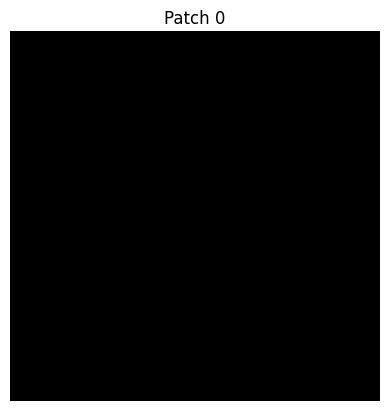

(3, 1024, 1024)


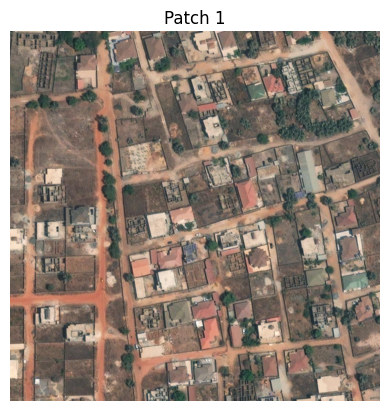

(3, 1024, 1024)


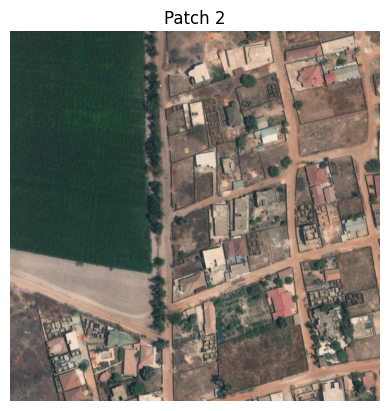

(3, 1024, 1024)


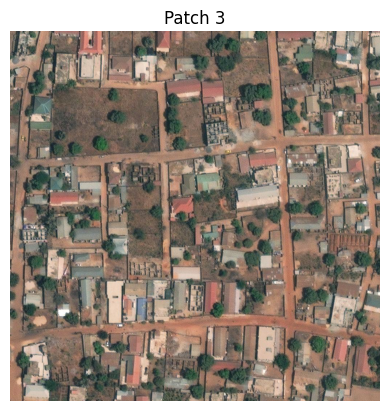

(3, 1024, 1024)


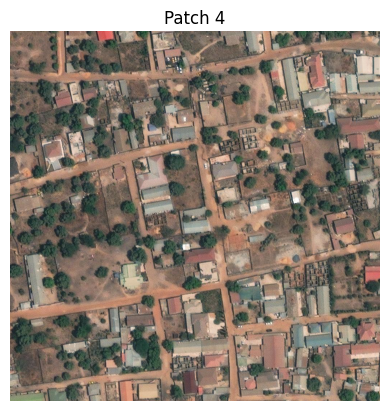

(3, 1024, 1024)


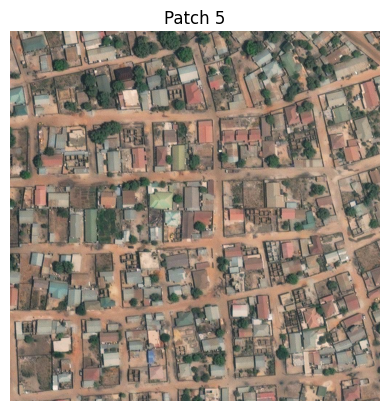

(3, 1024, 1024)


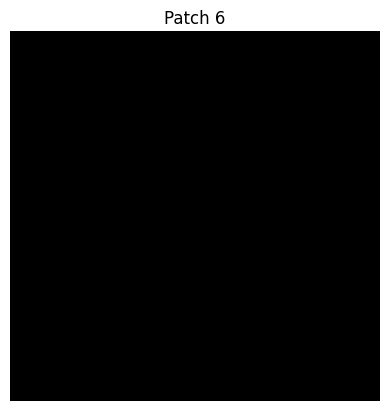

(3, 1024, 1024)


In [45]:
for i, sample in enumerate(dataloader):
    patch_numpy = sample['image'].numpy().squeeze().astype(np.uint8)
    plt.imshow(patch_numpy.transpose(1, 2, 0))  # Transpose to put channels last for matplotlib
    # Display the image
    plt.title(f'Patch {i}')
    plt.axis('off')
    plt.show()
    print(patch_numpy.shape)
    if i > 5:
        break

In [35]:
# Iterate over data
for i, patch in enumerate(dataloader):
    # Convert the patch tensor to numpy for visualization
    patch_numpy = patch.numpy().squeeze().astype(np.uint8)
    # Assuming the patch is a single channel or grayscale for simplicity
    # Since the patch is RGB, we can display it directly without squeezing
    plt.imshow(patch_numpy.transpose(1, 2, 0))  # Transpose to put channels last for matplotlib
    # Display the image
    plt.title(f'Patch {i}')
    plt.axis('off')
    plt.show()
    print(patch.shape)
    if i > 5:
        break

NameError: name 'noTBoundingBox' is not defined

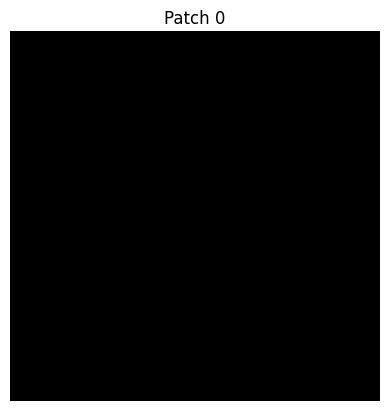

torch.Size([1, 3, 1024, 1024])


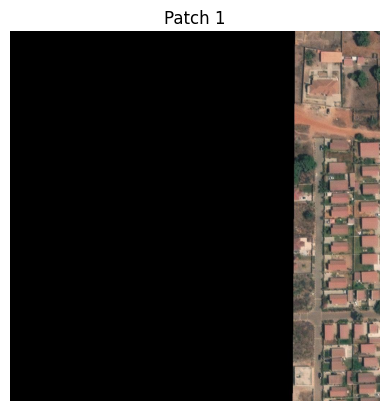

torch.Size([1, 3, 1024, 1024])


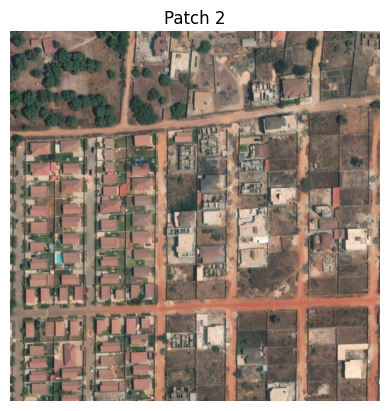

torch.Size([1, 3, 1024, 1024])


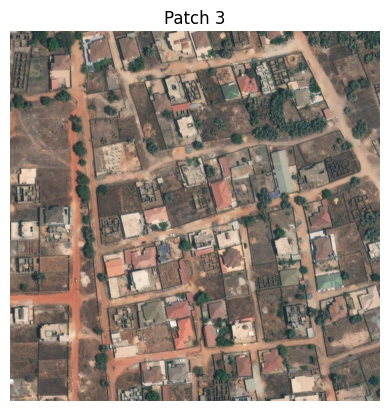

torch.Size([1, 3, 1024, 1024])


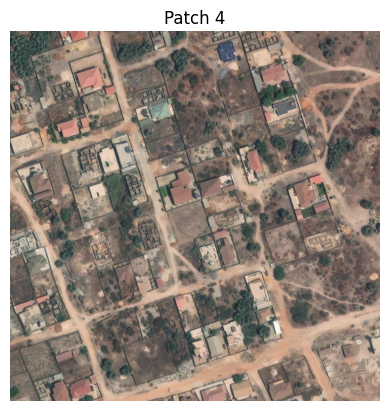

torch.Size([1, 3, 1024, 1024])


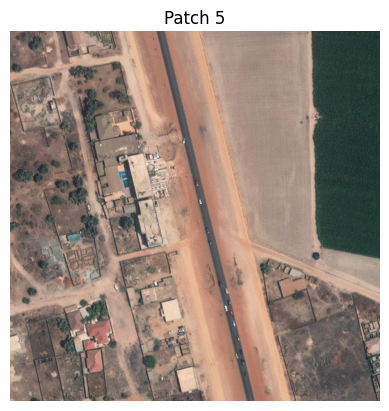

torch.Size([1, 3, 1024, 1024])


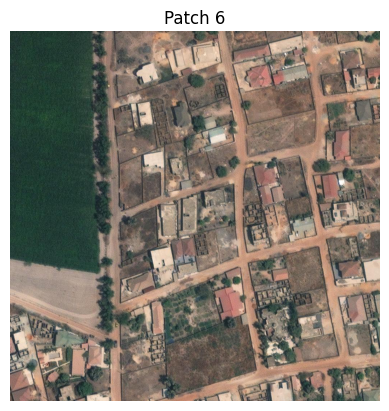

torch.Size([1, 3, 1024, 1024])


In [25]:
tiff_path = '/nfs/projects/overwatch/maxar-segmentation/maxar-open-data/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031233.tif'
patch_size = 1024 # in pixels
stride = 1024  # Overlapping stride in pixels

dataset = TiffPatchDataset(tiff_path)
sampler = BoundingBoxSampler(dataset, patch_size, stride)

# Custom collate function to handle bounding boxes
def collate_fn(batch):
    return torch.stack(batch)

dataloader = DataLoader(dataset, sampler=sampler)

# Iterate over data
for i, patch in enumerate(dataloader):
    # Convert the patch tensor to numpy for visualization
    patch_numpy = patch.numpy().squeeze().astype(np.uint8)
    # Assuming the patch is a single channel or grayscale for simplicity
    # Since the patch is RGB, we can display it directly without squeezing
    plt.imshow(patch_numpy.transpose(1, 2, 0))  # Transpose to put channels last for matplotlib
    # Display the image
    plt.title(f'Patch {i}')
    plt.axis('off')
    plt.show()
    print(patch.shape)
    if i > 5:
        break